# TP 9: Problème d'obstacle

$$
\newcommand{\sca}[2]{\langle #1\mid #2 \rangle}
\newcommand{\nr}[1]{\left\|#1\right\|}
\newcommand{\LL}{\mathrm{L}} 
\newcommand{\Rsp}{\mathbb{R}}
\newcommand{\Psp}{\mathbb{P}}
\newcommand{\Class}{\mathcal{C}}
$$
Soit $\Omega$ un ouvert de $\Rsp^2$ et $\Psi\in H^1_0(\Omega) \cap \Class^0(\Omega)$. On s'intéresse à la résolution du problème d'obstacle:
$$
\min_{v\in C} \int_\Omega \nr{\nabla v}^2
$$
où $C = \{ u\in H^1_0(\Omega) \mid u \geq \Psi \hbox{ p.p.}\}$.
On discrétise ce problème par la méthode des éléments finis en 2D. On part d'une triangulation $T_h$ de l'ouvert $\Omega$, et on note:
* $V_h$ l'espace des éléments finis $\Psp_1$ sur $T_h$, de sorte que $V_h\subseteq V := H^1(\Omega)$;
* $N_h :=\dim(V_h) = N_h$;
* $x_1,\dots,x_{N_h}$ les sommets de la triangulation. On suppose que les sommets du bord sont numérotés $J_h \subseteq \{ 1,\dots, N_h \}.$
* $V_{0h} = \{ v\in V_h\mid \forall k\in J_h, v(x_k) = 0 \}$
* $C_h = \{ v\in V_{0h}\mid \forall 1\leq i\leq N_h,~~ v(x_i) \geq \Psi(x_i) \}$

Le problème discret est alors donné par 
$$
\min_{v\in C_h} \int_\Omega \nr{\nabla v}^2.
$$

**Q1.** On note $W = (v_1,\dots,v_{N_h}) \in \Rsp^{N_h}$ les valeurs d'une fonction $v\in V_h$ sur les sommets $x_1,\dots,x_{N_h}$ (i.e. $v = \sum_{1\leq i\leq N_h} v_i \phi_i$ où $\phi_i$ est la base de $V_h$ formée des fonctions chapeau). Montrer que le problème peut être mis sous la forme

$$ \min_{W\in D_h} W^T  A W $$
$$D_h = \{ W\in \Rsp^{N_h} \mid \forall 1\leq i\leq N_h, W_i \geq \Psi(x_i) \hbox{ et } \forall k\in J_h,~ W_k = 0\}$$

*(Indication: on se rappellera de la caractérisation de la projection sur un convexe fermé)*

**Q2.** Soit $W\in \Rsp^{N_h}$. Montrer que la projection orthogonale de $W$ sur $D_h$ est donnée par

$$ \Pi_{D_h}(W) = \begin{cases} \max(W_i,\Psi(x_i)) & \hbox{ si } i\not\in J_h \\
0 & \hbox{ sinon } 
\end{cases}. $$

**Q3.** Écrire explicitement l'algorithme de gradient projeté (à pas constant) dans le cas où $J(W) = W^T A W$ et $K =  D_h$. Expliciter la condition nécessaire sur le pas de descente en fonction des valeurs propres de la matrice $A$.

<!---
[comment]: <> **Q4.** On s'intéresse au gradient projeté à pas optimal. On rappelle que l'algorithme de descente de gradient
[comment]: <> à pas optimal pour la minimisation (sans contrainte) de $W  \mapsto W^T A W$ est donné par $W^0 \in \Rsp^{N_h}$
[comment]: <> et $W^{k+1} = F(W)$ où $$ F(W) = W - 
--->

**Q4.** Implémenter cet algorithme dans le cas du disque $\Omega = \{ x^2 + y^2 \leq 4 \}$, en utilisant

$$ \Psi(x,y) = \begin{cases} \sqrt{1 - x^2 - y^2}, &\hbox{ si } x^2 + y^2 < 1 \\
0 &\hbox{ sinon } \end{cases} $$ 

Utiliser les fonction fournies pour trianguler le disque et calculer la matrice de rigidité. On pourra utiliser np.where pour construire la liste des indices des poins du bord.


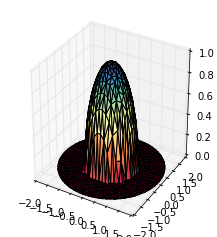

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as splinalg

def triangulation_disque(n):
    h = 2.0/n
    x,y = np.meshgrid(np.linspace(-2.,2.,n),
                      np.linspace(-2.,2.,n))
    x = x.reshape(n*n,1)
    y = y.reshape(n*n,1)
    X = np.hstack((x,y))
    J = np.where(X[:,0] * X[:,0] + X[:,1] * X[:,1] <= 4.0 - h)[0]
    X = X[J,:]
    t = np.linspace(0,2*np.pi-h, 2*np.pi/h)
    Y = np.vstack((2*np.cos(t), 2*np.sin(t))).T
    X = np.vstack((X,Y))
    T = tri.Triangulation(X[:,0], X[:,1]).triangles
    return X,T

# calcule la normale d'une famille de triangles triangle 3D, en déduit le gradient des fonctions dont 
# les triangles sont le graphe
def tri_gradient(A,B,C):
    N = np.cross(B - A, C-B)
    Gx = -N[:,0] / N[:,2]
    Gy = -N[:,1] / N[:,2]
    return Gx, Gy

def matrice_rigidite(X,T):
    nt = T.shape[0];
    npts = X.shape[0];
  
    A = X[T[:,0],:]; # liste des points A des triangles
    B = X[T[:,1],:]; # liste des points B des triangles
    C = X[T[:,2],:]; # liste des points C des triangles
  
    # calcul de dx et dy sur chaque triangle, en fonction de la valeur de
    # la fonction aux sommets du triangle
    Z = np.zeros((nt,1));
    I = np.ones((nt,1));
    [Gx1,Gy1] = tri_gradient(np.hstack((A,I)),np.hstack((B,Z)),np.hstack((C,Z)));
    [Gx2,Gy2] = tri_gradient(np.hstack((A,Z)),np.hstack((B,I)),np.hstack((C,Z)));
    [Gx3,Gy3] = tri_gradient(np.hstack((A,Z)),np.hstack((B,Z)),np.hstack((C,I)));
  
    # assemblage des matrices creuses
    # pour chaque triangle 1\leq t \leq nt, on a trois coefficients non nuls
    # en (t,a), (t,b), (t,c) où a = T[i,1], b=T[i,2], c=T[i,3]
    I = np.hstack((np.arange(nt), np.arange(nt), np.arange(nt)))
    J = np.hstack((T[:,0], T[:,1], T[:,2]))
    Sx = np.hstack((Gx1,Gx2,Gx3))
    Sy = np.hstack((Gy1,Gy2,Gy3))
    
    # les matrices creuses sont construites de la manière suivante:
    # pour tout l dans 0, ..., len(J)-1, on pose dx[I[k],J[k]] = Sx[k]
    dx = sp.csc_matrix((Sx,(I,J)),shape=(nt,npts))
    dy = sp.csc_matrix((Sy,(I,J)),shape=(nt,npts))
    
    # calcul de l'aire des triangles:
    AB = B-A
    BC = C-B
    aires = .5*(AB[:,0]*BC[:,1] - AB[:,1]*BC[:,0])
    
    return dx.T*sp.diags(aires)*dx + dy.T*sp.diags(aires)*dy

[X,T] = triangulation_disque(30)
A = matrice_rigidite(X,T)
N = len(X)
tau = 1e-1

Psi = np.sqrt(np.maximum(0.0, 1.0 - X[:,0]*X[:,0] - X[:,1]*X[:,1]))

# affichage du graphe d'une fonction sur R^2
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1, 2, 1, projection='3d',)
ax.plot_trisurf(X[:,0],X[:,1],Psi,triangles=T, cmap=plt.cm.Spectral, shade=True)
plt.show()

# compléter


**Q5.** On admet que si $u \in \Class^1(\bar{\Omega}) \cap H^2_0(\bar{\Omega})$ vérifie 
$$ \begin{cases}
- \Delta u = 0 &\hbox{ si } u > \Psi \\
- \Delta u \geq 0 &\hbox{ quand } u = \Psi 
\end{cases},$$
alors $u$ est solution du problème d'obstacle. La difficulté principale est de trouver l'ensemble de contact $\{ x \in \Omega \mid u(x)=\Psi(x)\}$. En posant $u(x,y) = f(r)$ (en  coordonnées polaires) avec $f: [0,2]\to\Rsp$, montrer qu'il existe une solution vérifiant ces hypothèses.

*(Indication: supposer que $u = \Psi$ sur $B(0,a)$ et $\Delta u = 0$ sur $B(0,2)\setminus B(0,a)$, et trouver $a \in (0,2)$ tel que les conditions de Dirichlet soient vérifiées.)*

**Q6.** Démontrer que $U$ est optimal pour le problème discret ($\min_{W\in K_h} W^T A W$) si et seulement si il vérifie les conditions suivantes, appellées conditions de *Karush-Kuhn-Tucker* (KKT):

$$ \begin{cases}
U_i = 0 & \hbox{ si } i \in J_h \hbox{ (bord) } \\
- A U_i \geq 0 & \hbox{ si } U_i = \Psi_i \\
- A U_i = 0 & \hbox{ si } U_i > \Psi_i 
\end{cases} $$

*(Indication: le sens direct (optimalite $\Longrightarrow$ KKT) se démontre comme dans le cours. Pour la réciproque, il faut se rappeler que, si $J(W) = W^T A W$, alors par convexité, $J(W) \geq J(U) + \sca{\nabla J(U)}{W - U}$ pour tout $W\in \Rsp^{N_h}$)*

**Q7.** Vérifier numériquement que l'on trouve bien une solution radiale, avec la bonne valeur de $a$ (en traçant l'ensemble $\{x_i \mid U_i = \Psi_i\}$).


In [4]:
# compléter

**Q8.** En déduire un critère permettant de vérifier la convergence de l'algorithme du gradient projeté. Estimer (numériquement) la vitesse de convergence de l'algorithme en fonction du nombre d'itérations ($h$ restant fixé).
